In [1]:
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm 
import json
import os
import datetime
import re
import csv
import time
import pandas as pd
from nltk.stem import *
from collections import Counter
from functools import reduce
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk import tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# data = load_tsv()
data = pd.read_csv("tsv_dataframe.csv",index_col=0)

#Reset Index
data.reset_index(inplace = True, drop=True)

print(data.shape)
print(data.info)

(7200, 15)
<bound method DataFrame.info of                          placeName  \
0                City Hall Station   
1     The Winchester Mystery House   
2         Center for Puppetry Arts   
3          Amityville Horror House   
4          Yuma Territorial Prison   
...                            ...   
7195         Old Tunnel Bat Colony   
7196               The Bunny Hutch   
7197                 The Washhouse   
7198      Takeshima Fantasy Museum   
7199    Dead Children's Playground   

                                              placeTags  numPeopleVisited  \
0     subways,subterranean,infrastructure,subterrane...              1834   
1     follies and grottoes,outsider architecture,ecc...              3723   
2                         sesame street,puppets,museums               705   
3     hoaxes and pseudoscience,haunted,film location...               367   
4                          prisons,crime and punishment               422   
...                                   

##### the following work carries forward a study of data from the "Atlas Obscura" website, an American online magazine and travel firm, catalogues unusual and obscure tourist locations. We considered 7200 touristic attractions around the world (rows of the dataframe) for a total of 15 informations (the columns). The goals of the project are to create two search engine, define a new score, visualize in a map the most relevant places etc. but first of all let's have a look with an exploratory data analysis (EDA) in our data.

In [375]:
print(data.isna().sum())

placeName             0
placeTags            34
numPeopleVisited      0
numPeopleWant         0
placeDesc             0
placeShortDesc        0
placeNearby           0
placeAdress          34
placeAlt              0
placeLong             0
placeEditors          6
placePubDate          1
placeRelatedList      1
placeRelatedPlace    34
placeURL              0
dtype: int64


In [376]:
data = data.dropna(subset = ["placePubDate"])
data = data.dropna(subset = ["placeEditors"])

##### Our dataframe contains some NA values, in particulary in the informations "Place Tags", "Place Adress", "Place Related Place" (34 NA values each), anyway for our analysis we care about the place editors (6 NA) and the Place Pubblice Date (1 NA) removing this values to make it possibile our analysis.

In [377]:
import seaborn as sns

C:\Users\Marco\AppData\Local\Temp\ipykernel_13176\484760028.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.placePubDate2 = pd.to_datetime(data.placePubDate)


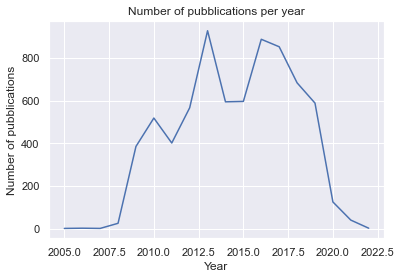

The year with more pubblications: 2013
Total number of pubblications in that year: 887


In [378]:
data.placePubDate
data.placePubDate2 = pd.to_datetime(data.placePubDate)
data.placePubDate2['year'] = data.placePubDate2.dt.year
conteggio = data.placePubDate2['year'].astype(int)
conteggio = conteggio.value_counts(dropna=False)
sns.set_theme()
grafico1 = sns.lineplot(data=conteggio, palette = "plasma")
grafico1.set(xlabel = "Year", ylabel = "Number of pubblications", title = "Number of pubblications per year")
plt.show()
print("The year with more pubblications:", data.placePubDate2['year'].value_counts().idxmax())
print("Total number of pubblications in that year:", data.placePubDate2['year'].value_counts()[2016])

##### Atlas Obscura was born in 2009, with the firsts pubblications goes up to the previous years. The data we have considered tell us that the peak of publications can be identified in 2013 when 887 places have been registred. In the last years, instead, the number of pubblications decresed. Perhaps the covid-19 pandemic affected not only travels but also travel-related publications.

In [379]:
data.describe().applymap('{:,.2f}'.format)

,numPeopleVisited,numPeopleWant,placeAlt,placeLong
count,"7,193.00","7,193.00","7,193.00","7,193.00"
mean,418.87,913.72,40.19,-55.61
std,530.32,666.85,12.47,62.71
min,12.00,406.00,-77.72,-168.06
25%,133.00,522.00,35.99,-97.74
50%,247.00,691.00,40.73,-77.04
75%,479.00,"1,038.00",46.07,-1.16
max,"6,639.00","8,603.00",78.24,176.39


##### The average of people (that belong to the Atlas Obscura community) that visited a site is 418.87, instead the average of people that would like to visit a precise site is 913.72. Interesting is the information about the minimum (12 for "numPeopleVisited" and 406 for "numPeopleWant"): infact the value in the variable "number of people want" is much bigger than "number of people visited". What can be deduced is that even a touristic location that is very unknown and rarely visited create a lof of curiosity in the travelers. 

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


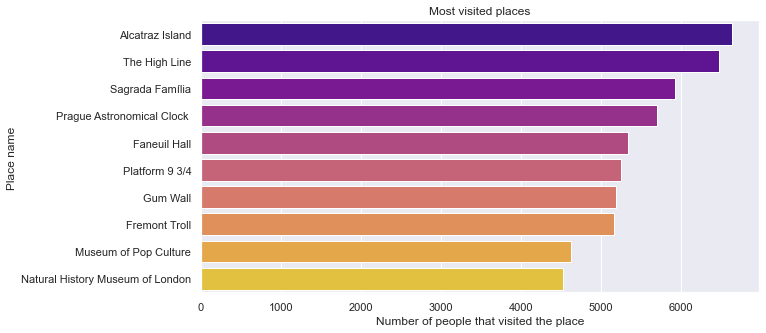

In [380]:
top_meta = data.sort_values(["numPeopleVisited"], ascending = False).head(10)
top_meta[["placeName","numPeopleVisited"]]
plt.figure(figsize=(10,5))
grafico3 = sns.barplot(top_meta.numPeopleVisited, top_meta.placeName, palette="plasma")
grafico3.set(xlabel = "Number of people that visited the place", ylabel = "Place name ", title = "Most visited places")
plt.show()

###### The top visited attractions are the ones in the barplot. At the first place there is Alcatraz Island in San Francisco with 6639 visitors. At the second place there is The High Line in New York with 6478 visitors and complete the podium the Sagrada Familia in Barcellona with 5918 visitors.

D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


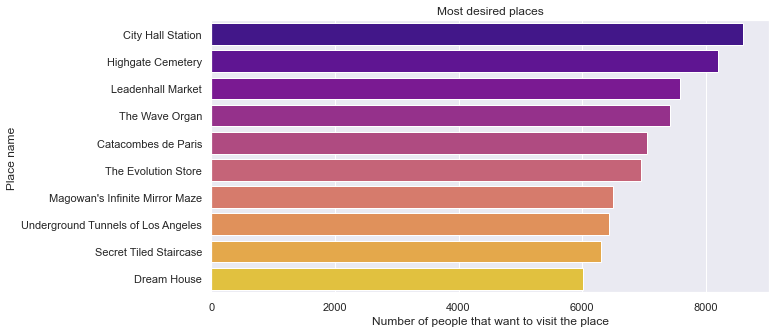

In [381]:
top_futur_meta = data.sort_values(["numPeopleWant"], ascending = False).head(10)
top_futur_meta[["placeName","numPeopleWant"]]
plt.figure(figsize=(10,5))
grafico3 = sns.barplot(top_futur_meta.numPeopleWant, top_futur_meta.placeName, palette="plasma")
grafico3.set(xlabel = "Number of people that want to visit the place", ylabel = "Place name ", title = "Most desired places")
plt.show()

##### Different it's the situation for the Most desidered places. In fact, they don't match with the most visited places. At the first place there is the City Hall Station in New York with 8603 people that want to go there, at the second place there is the Highgate Cemetery in London which is in the favourite places of 8206 people. At the third place there is the Leadenhall Market in London with 7593 units.

##### The mismatch between the most visited and most desired places leads us to study the correlation between these two variables.

0.4638404488887379


<AxesSubplot:xlabel='numPeopleVisited', ylabel='numPeopleWant'>

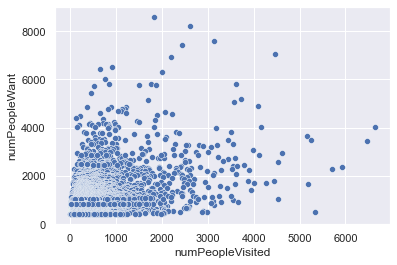

In [382]:
var1 = data.numPeopleVisited
var2 = data.numPeopleWant
print(var1.corr(var2, method = "pearson"))
grafico4 = sns.scatterplot(x="numPeopleVisited", y="numPeopleWant", data=data, palette = "plasma");
grafico4

##### Pearson's correlation index is low  (0.46), so there is not a strong liner correlation on average between the two variables and a weak linear dependence.

In [383]:
import matplotlib.pyplot as plt

[('of', 1041), ('McBride', 713), ('Black', 269), ('Annetta', 202), ('Jackson', 184), ('J', 158), ('Experiences', 149), ('Szendrey', 127), ('Jacobson', 123), ('Regret', 109)]


D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


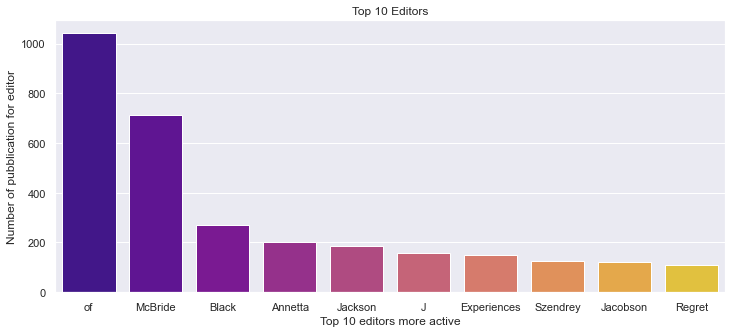

In [384]:
d = {}
n = len(data)

for i in range(n):
    l = []
    l = data.iloc[i]["placeEditors"]
    l = l.split(' ')
    for j in l:
        if not j in d:
            d[j] = 1
        else:
            d[j] = d[j] + 1
top_editors = sorted(d.items(), key=lambda x: x[1], reverse = True)
print(top_editors[:10])

keys = []
values = []
for i in range(10):
    keys.append(top_editors[i][0])
    values.append(top_editors[i][1])

plt.figure(figsize=(12,5))
grafico5 = sns.barplot(keys, values, palette="plasma")
grafico5.set(xlabel = "Top 10 editors more active", ylabel = "Number of pubblication for editor", title = "Top 10 Editors")
plt.show()

##### This barplot represent the top 10 editors (the people that writed more publications in the website). The first place belong to "of" (1041), the second to "McBride" (713) and the third to "Black" 269. The first two editors can be considered outliers because they have a very high number of publications compared to other editors.

[('architecture', 942), ('architectural oddities', 720), ('museums', 692), ('museums and collections', 581), ('collections', 504), ('art', 500), ('ruins', 500), ('nature', 493), ('geology', 470), ('ecosystems', 468)]


D:\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


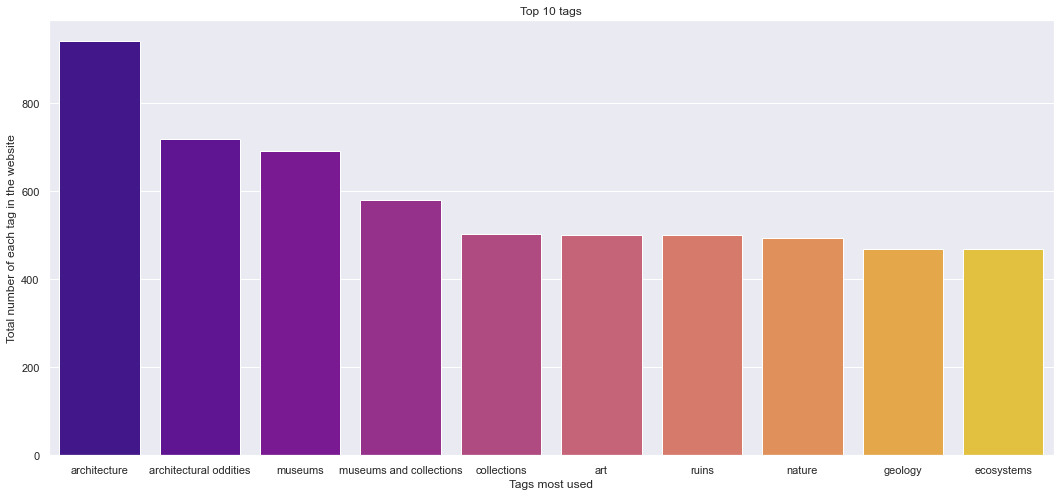

In [385]:
d = {}
n = len(data)

for i in range(n):
    l = []
    l = data.iloc[i]["placeTags"]
    l = str(l)
    l = l.split(',')
    for j in l:
        if not j in d:
            d[j] = 1
        else:
            d[j] = d[j] + 1
top_editors = sorted(d.items(), key=lambda x: x[1], reverse = True)
print(top_editors[:10])

keys = []
values = []
for i in range(10):
    keys.append(top_editors[i][0])
    values.append(top_editors[i][1])

plt.figure(figsize=(18,8))
grafico6 = sns.barplot(keys, values, palette="plasma")
grafico6.set(xlabel = "Tags most used", ylabel = "Total number of each tag in the website", title = "Top 10 tags")
plt.show()

##### In the end of this analysis, collecting all the tags on the site, is viewable that architecture is the topic with more places in the website (942), after, more in particular, there are architectural oddities (720), and later museums (692).